# Ill-Gaussian Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random

using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

## MCHMC

In [3]:
d = 100
k = 100
m = Vector(LinRange(1, 100, d))
e = 10 .^ LinRange(log(1/sqrt(k)), log(sqrt(k)), d)
cov_matt = Diagonal(e);

In [4]:
ill_gaussian_target = GaussianTarget(m, cov_matt)
ill_gaussian_spl = MCHMC(0.0, 0.5; varE_wanted=1.0, sigma=ones(d));

In [5]:
ill_gaussian_samples = Sample(ill_gaussian_spl, ill_gaussian_target, 200000;
                             dialog=true);

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 0.4284010276539775
eps: 0.8855483616149739 --> VarE: 0.7785955995337359
eps: 1.093144245108136 --> VarE: 0.9701261323218648


[ Info: Found eps: 1.093144245108136 ✅


In [6]:
ill_gaussian_d1 = [sample[1] for sample in ill_gaussian_samples]
ill_gaussian_d50 = [sample[50] for sample in ill_gaussian_samples];

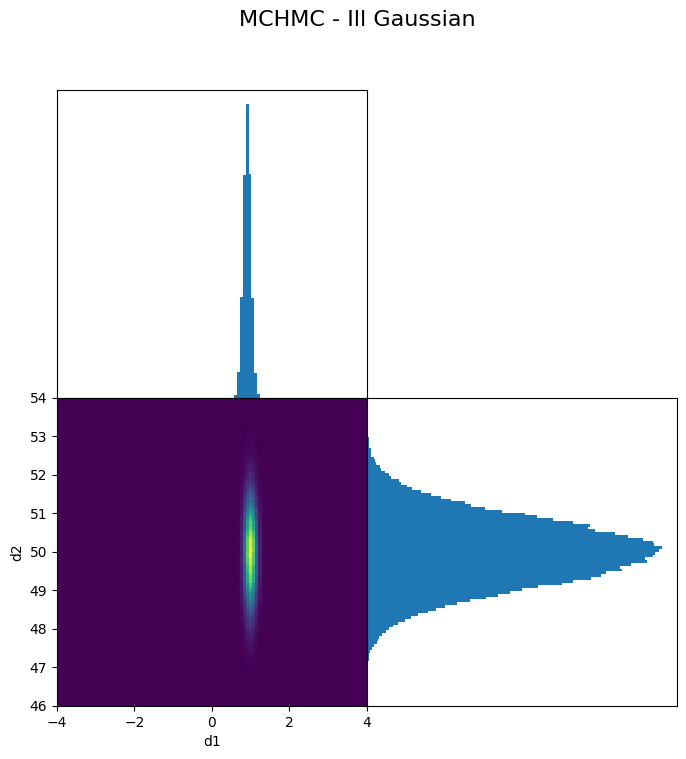

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Ill Gaussian", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(ill_gaussian_d1, bins=100, range=[-4,4])
axis[1,1].set_yticks([])

axis[2,2].hist(ill_gaussian_d50, bins=100, orientation="horizontal", range=[46, 54])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(ill_gaussian_d1, ill_gaussian_d50, bins=100, range=[[-4,4],[46, 54]])
axis[2,1].set_xlabel("d1")
axis[2,1].set_ylabel("d2");

## NUTS

In [8]:
using AdvancedHMC
using LogDensityProblems

In [9]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = -ill_gaussian_target.nlogp(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [19]:
# Choose parameter dimensionality and initial parameter value
initial_θ = ill_gaussian_target.prior_draw(0.0)
ℓπ = LogTargetDensity(d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 100_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
ill_gaussian_samples_hmc, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:01:18
  iterations:                    100000
  n_steps:                       15
  is_accept:                     true
  acceptance_rate:               0.8439738017548858
  log_density:                   -134.7797564387065
  hamiltonian_energy:            184.00185227459755
  hamiltonian_energy_error:      0.0141216562360853
  max_hamiltonian_energy_error:  0.41736798630714134
  tree_depth:                    4
  numerical_error:               false
  step_size:                     0.38588178967561976
  nom_step_size:                 0.385881

([[-0.28683707108876605, 0.5247902140651011, 0.5837847132991665, -1.033688274408283, 0.7252549412522272, 0.2347706398312952, -0.22623390956428835, 1.3641929284591412, 2.1298210664004578, -1.6023574282253894  …  0.005940824744808844, 1.0202774314102383, 1.0594297741299235, 0.43377378162806557, 1.2657588811335734, 1.2183943197357259, -0.18035731934416574, 0.795919404336355, 0.4213486551731578, 0.4544432943872082], [-0.28683707108876605, 0.5247902140651011, 0.5837847132991665, -1.033688274408283, 0.7252549412522272, 0.2347706398312952, -0.22623390956428835, 1.3641929284591412, 2.1298210664004578, -1.6023574282253894  …  0.005940824744808844, 1.0202774314102383, 1.0594297741299235, 0.43377378162806557, 1.2657588811335734, 1.2183943197357259, -0.18035731934416574, 0.795919404336355, 0.4213486551731578, 0.4544432943872082], [2.2495522408973345, 3.2578587584254617, 4.946101625414615, 7.613690921631693, 7.442336173325945, 8.783202787078716, 9.922637654250334, 9.998925903627123, 10.077799733370

In [26]:
ill_gaussian_d1_hmc = [sample[1] for sample in ill_gaussian_samples_hmc]
ill_gaussian_d50_hmc = [sample[50] for sample in ill_gaussian_samples_hmc];

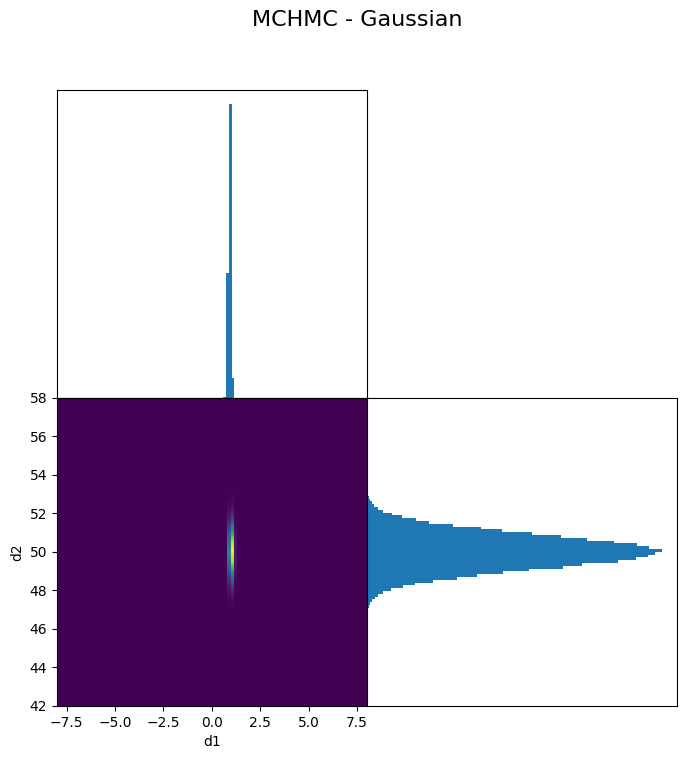

In [27]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Gaussian", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(ill_gaussian_d1_hmc, bins=100, range=[-8,8])
axis[1,1].set_yticks([])

axis[2,2].hist(ill_gaussian_d50_hmc, bins=100, orientation="horizontal", range=[42, 58])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(ill_gaussian_d1_hmc, ill_gaussian_d50_hmc, bins=100, range=[[-8,8],[42, 58]])
axis[2,1].set_xlabel("d1")
axis[2,1].set_ylabel("d2");